# 02 Hidden Markov Model

In this note, using a toy model as an illustrative example,  we show how we can use Hidden Markov Models to estimate latent variables from observations

In [174]:
using PyPlot, Random
using Revise, MDToolbox
ENV["COLUMNS"] = 130; #display width for MDToolbox
Random.seed!(755);

# Relation between daily weathers and daily ice cream sales

Fist, let us describe daily weathers described by $X$

|  Weather |   value   |
| ---------| --------- |
|  Rain   |  x = 1    |
|  Cloudy  |  x = 2    |
|  Sunny   |  x = 3    |

Suppose that daily sales of ice creams $Y$ can be modeld by weather variable $X$, as follows

\begin{aligned}
Y = X + \epsilon
\end{aligned}

Here, epsion is a Gaussian random variable whose mean is zero and variance is one. Thus, the probability distribution of $Y$ is 

\begin{aligned}
P(y | X=x) = \frac{1}{\sqrt{2 \pi}} \exp \left( - \frac{(y-x)^2}{2} \right)
\end{aligned}

Then, if the daily sales of the ice cream sales are only recorded as daily time-series data, can we estimate the daily weathers from the data ?

In the following, we estimate the weathers by using Hidden Markov modeligs

# Viterbi algorithm

Supoose that the transition probabilitities $T_{i,j}$ of weathers from today ($X_i$) to tomorrow ($X_j$) can be described as follows

|                  |  Rain (tomorrow)  |  Cloudy(tomorrow) |  Sunny (tomorrow) |
| -----------------| ----------------- | ----------------- | ----------------- |
|  Rain (today)    |     0.200004      |     0.257922      |     0.542074      |
|  Cloudy (today)  |     0.242095      |     0.300014      |     0.457891      |
|  Sunny (today)   |     0.157926      |     0.142121      |     0.699953      |

These transition probabilities satisfies the detailed balance

\begin{aligned}
p_i T_{ij} = p_j T_{ji}
\end{aligned}

When daisy sales of ice creams for $N$ days are given as time-series data $y_n (n=1,\ldots,N)$, then the likelihood function of observing the whole data is written as follows:

\begin{aligned}
L\left( Data | T \right)=\sum_{x_{1}=1}^{3} \cdots \sum_{x_{N}=1}^{3} p\left(x_1 \right) p\left(y_1 | x_1 \right) \prod_{n=2}^{N} T_{x_{n-1} x_{t}} p\left(y_n | x_n \right)
\end{aligned}

Again, $p(y | x )$ is 

\begin{aligned}
P(y | x) = \frac{1}{\sqrt{2 \pi}} \exp \left( - \frac{(y-x)^2}{2} \right)
\end{aligned}

This likelihood function can be efficiently maximized by Viterbi algorithm. By maximizing the likelihood over $x_n (n=1,\ldots, N)$, we can obtaine the best estimate for daily weathers. 

In [175]:
# transition probabilities of weather x
T = [   0.200004  0.257922  0.542074
        0.242095  0.300014  0.457891
        0.157926  0.142121  0.699953]

# equilibrium probabilities
p =  [0.18188946819002771, 0.19378061616295644, 0.6243299156470158]

3-element Array{Float64,1}:
 0.18188946819002771
 0.19378061616295644
 0.6243299156470158

In [176]:
# make test data
N = 100
weather_ground_truth = msmgenerate(N, T, p)
sales = weather_ground_truth .+ randn(N)

emission_probability = (1.0./sqrt(2.0*pi)) .* exp.( - (sales .- [1.0 2.0 3.0]).^2 ./ 2.0 )

100×3 Array{Float64,2}:
 0.124198     0.347089     0.356839
 0.165242     0.378085     0.318247
 0.0963276    0.315329     0.379735
 0.0158266    0.000756668  1.33085e-5
 0.0268175    0.166125     0.378581
 0.000127299  0.00426855   0.0526551
 0.23069      0.398508     0.253252
 0.112212     0.334668     0.367194
 0.131099     0.353485     0.350628
 0.166464     0.378769     0.317055
 0.0908834    0.307846     0.383609
 0.314132     0.380389     0.169453
 0.39331      0.201536     0.0379907
 ⋮                         
 0.398484     0.253558     0.0593541
 0.0462048    0.223518     0.397779
 0.37999      0.314866     0.0959807
 0.0242839    0.156934     0.373096
 0.0304515    0.17848      0.384835
 0.0191144    0.136394     0.358044
 0.146859     0.366216     0.335953
 0.229496     0.398412     0.254445
 0.0328205    0.18607      0.388071
 0.0297998    0.17633      0.383836
 0.388817     0.295852     0.0828153
 0.00737125   0.0754079    0.283791

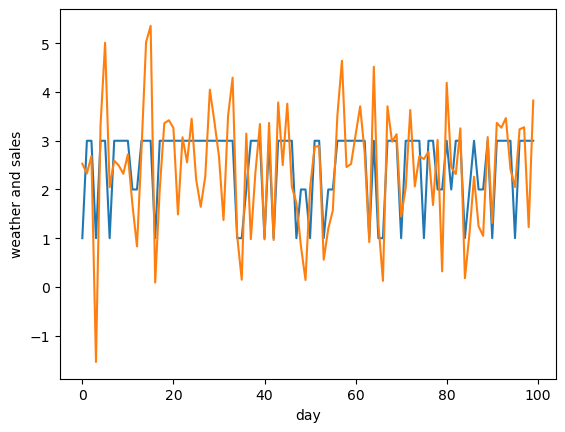

PyObject Text(24.000000000000007, 0.5, 'weather and sales')

In [177]:
plot(weather_ground_truth)
plot(sales)
xlabel("day")
ylabel("weather and sales")

In [178]:
p

3-element Array{Float64,1}:
 0.18188946819002771
 0.19378061616295644
 0.6243299156470158

In [179]:
weather_estimated = msmviterbi(collect(1:N), T, p, emission_probability')

100-element Array{Int64,1}:
 3
 3
 3
 1
 3
 3
 3
 3
 3
 3
 3
 3
 1
 ⋮
 1
 3
 3
 3
 3
 3
 3
 3
 3
 3
 3
 3

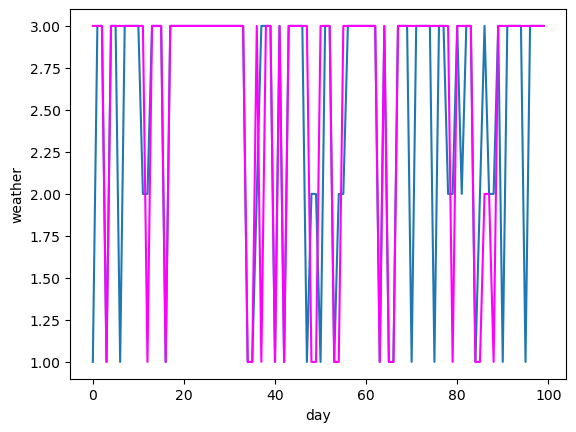

PyObject Text(24.000000000000007, 0.5, 'weather')

In [180]:
plot(weather_ground_truth)
plot(weather_estimated, color=:magenta)
xlabel("day")
ylabel("weather")

In [181]:
# correct estimation rate
sum(weather_ground_truth .== weather_estimated)./N

0.78

## Baum-Welch algorithm (Forward-Backward algorithm)

In more general situlation, we don't know the transition probabilities of weathers a priori. So, it is bettter if we can estimate not only daily weathers but also the transition probabilities from given time-series data. 

This can be done if we can maximize the likelihood function over the transition probabilities $T_{ij}$.

We can use Baum-Welch algorithm for this purpose. In the following, we apply this algorithm to the same data set as above.

In [182]:
# create initial values of transition probabilities
T0 = rand(Float64, 3, 3)
T0 .= T0 ./ sum(T0, dims=2)

T0, p0 = msmtransitionmatrix(T0)

10 iteration  LogLikelihood = -2.71360e+00  delta = 1.86896e-04  tolerance = 1.00000e-04


([0.3860744702405311 0.40308420569071035 0.2108413240687584; 0.14677661735352435 0.7784055492777577 0.0748178333687179; 0.2217801306265577 0.21612794996296045 0.5620919194104819], [0.21290548342385215, 0.5846901176799705, 0.20240439889617728])

In [183]:
T_estimated, p_estimated, dummy = msmbaumwelch([collect(1:N)], T0, p0, emission_probability', TOLERANCE=10^(-8))

100 iteration LogLikelihood = -1.622722e+02  delta = 1.370785e-04  tolerance = 1.000000e-08
200 iteration LogLikelihood = -1.622662e+02  delta = 2.673851e-05  tolerance = 1.000000e-08
300 iteration LogLikelihood = -1.622646e+02  delta = 8.134246e-06  tolerance = 1.000000e-08
400 iteration LogLikelihood = -1.622641e+02  delta = 2.712787e-06  tolerance = 1.000000e-08
500 iteration LogLikelihood = -1.622640e+02  delta = 9.500182e-07  tolerance = 1.000000e-08
600 iteration LogLikelihood = -1.622639e+02  delta = 3.396612e-07  tolerance = 1.000000e-08
700 iteration LogLikelihood = -1.622639e+02  delta = 1.224104e-07  tolerance = 1.000000e-08
800 iteration LogLikelihood = -1.622639e+02  delta = 4.424570e-08  tolerance = 1.000000e-08
900 iteration LogLikelihood = -1.622639e+02  delta = 1.601001e-08  tolerance = 1.000000e-08


([0.18674497896669726 0.1156200878711304 0.6976349331621725; 0.08917873953079072 0.2868295668984021 0.6239916935708072; 0.19680312886085913 0.22822044796425484 0.5749764231748861], [0.1711937444015151, 0.22195240563875587, 0.606853849959729], [0.12419782454611829 0.16524214764141604 … 0.38881688100635475 0.007371249622954311; 0.34708875604899536 0.3780854963622602 … 0.295852370964778 0.07540788384360268; 0.35683925101614866 0.31824729641690597 … 0.08281528753929399 0.28379053477738336])

In [184]:
T

3×3 Array{Float64,2}:
 0.200004  0.257922  0.542074
 0.242095  0.300014  0.457891
 0.157926  0.142121  0.699953

In [185]:
T0

3×3 Array{Float64,2}:
 0.386074  0.403084  0.210841
 0.146777  0.778406  0.0748178
 0.22178   0.216128  0.562092

In [186]:
T_estimated

3×3 Array{Float64,2}:
 0.186745   0.11562  0.697635
 0.0891787  0.28683  0.623992
 0.196803   0.22822  0.574976

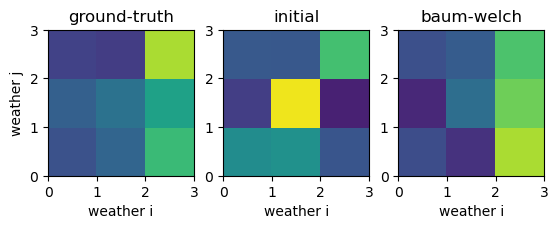

PyObject Text(0.5, 1.0, 'baum-welch')

In [187]:
a = subplot(1,3,1)
pcolor(T, vmin=0, vmax=0.8)
a.set_aspect(:equal)
xlabel("weather i"); ylabel("weather j")
title("ground-truth")

a = subplot(1,3,2)
pcolor(T0, vmin=0, vmax=0.8)
a.set_aspect(:equal)
xlabel("weather i")
title("initial")

a = subplot(1,3,3)
pcolor(T_estimated, vmin=0, vmax=0.8)
a.set_aspect(:equal)
xlabel("weather i")
title("baum-welch")

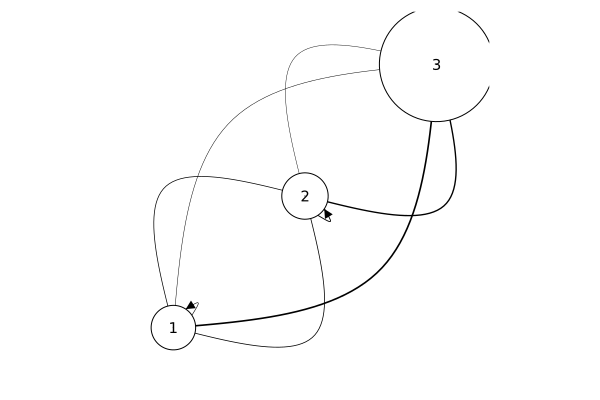

In [188]:
msmplot(T, x=[1, 2, 3], y=[1, 2, 3], names=1:3, dpi=100)

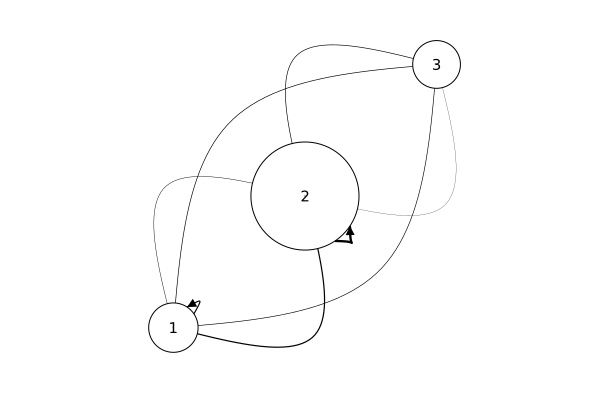

In [189]:
msmplot(T0, x=[1, 2, 3], y=[1, 2, 3], names=1:3, dpi=100)

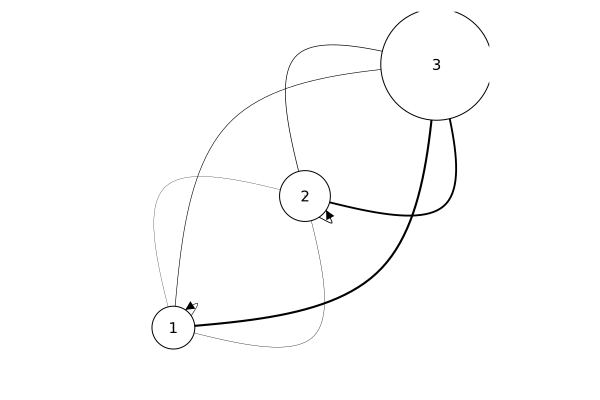

In [190]:
msmplot(T_estimated, x=[1, 2, 3], y=[1, 2, 3], names=1:3, dpi=100)

In [191]:
weather_estimated2 = msmviterbi(collect(1:N), T_estimated, p_estimated, emission_probability')

100-element Array{Int64,1}:
 3
 3
 3
 1
 3
 3
 3
 3
 3
 3
 3
 3
 1
 ⋮
 1
 3
 1
 3
 3
 3
 3
 3
 3
 3
 1
 3

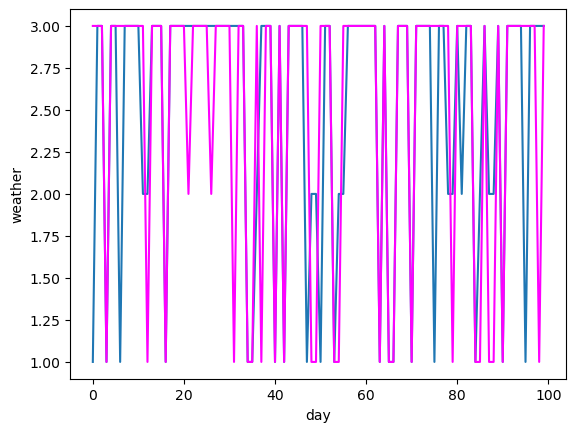

PyObject Text(24.000000000000007, 0.5, 'weather')

In [192]:
plot(weather_ground_truth)
plot(weather_estimated2, color=:magenta)
xlabel("day")
ylabel("weather")

In [193]:
# correct estimation rate
sum(weather_ground_truth .== weather_estimated2)./N

0.76